# The Price is Right
A more complex solution for estimating prices of goods.

1. This notebook: create a RAG database with our 400,000 training data
2. Pr11.ThePriceIsRight-Rag2.1 notebook: visualize in 2D
3. Pr11.ThePriceIsRight-Rag2.2 notebook: visualize in 3D
4. Pr11.ThePriceIsRight-Rag2.3 notebook: build and test a RAG pipeline with GPT-4o-mini
5. Pr11.ThePriceIsRight-Rag2.4 notebook: (a) bring back our Random Forest pricer (b) Create a Ensemble pricer that allows contributions from all the pricers

Phew! That's a lot to get through in one day!


In [1]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from items import Item
from testing import Tester

In [3]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [4]:
openai = OpenAI()

In [5]:
with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [6]:
test[0].prompt

'How much does this cost to the nearest dollar?\n\n3-in-1 Pocket Hole Jig Kit, Woodworking Doweling Jig Set, Positioning Punch Tools with Positioning Clip, Adjustable Drilling Guide for Puncher Locator Carpentry Woodwork\n(Specifics)This finely machined hole drilling guide kit was designed with precision scale on its main body, the scale is adjustable according to the thickness of the plank to make your woodworking much precise and convenient. (Material) The drill kit and ring are made of carbon steel, the positioner is made of Anti-Rust hence durable aluminum. (Multi-function) Multi-purpose drill guide, for drilling dowel holes and vertical holes. Complete set of combinations meet your different drilling needs under multiple circumstances. (Premium Precision) The oblique jig was processed in high precision CNC machining to ensure an exact and\n\nPrice is $60.00'

In [7]:
def make_context(similars, prices):
    message = "To provide some context, here are some other items that might be similar to the item you need to estimate.\n\n"
    for similar, price in zip(similars, prices):
        message += f"Potentially related product:\n{similar}\nPrice is ${price:.2f}\n\n"
    return message

In [8]:
def messages_for(item, similars, prices):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = make_context(similars, prices)
    user_prompt += "And now the question for you:\n\n"
    user_prompt += item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [9]:
DB = "products_vectorstore"

In [10]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [11]:
def description(item):
    text = item.prompt.replace("How much does this cost to the nearest dollar?\n\n", "")
    return text.split("\n\nPrice is $")[0]

In [12]:
description(test[0])

'3-in-1 Pocket Hole Jig Kit, Woodworking Doweling Jig Set, Positioning Punch Tools with Positioning Clip, Adjustable Drilling Guide for Puncher Locator Carpentry Woodwork\n(Specifics)This finely machined hole drilling guide kit was designed with precision scale on its main body, the scale is adjustable according to the thickness of the plank to make your woodworking much precise and convenient. (Material) The drill kit and ring are made of carbon steel, the positioner is made of Anti-Rust hence durable aluminum. (Multi-function) Multi-purpose drill guide, for drilling dowel holes and vertical holes. Complete set of combinations meet your different drilling needs under multiple circumstances. (Premium Precision) The oblique jig was processed in high precision CNC machining to ensure an exact and'

In [13]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [14]:
def vector(item):
    return model.encode([description(item)])

In [15]:
def find_similars(item):
    results = collection.query(query_embeddings=vector(item).astype(float).tolist(), n_results=5)
    documents = results['documents'][0][:]
    prices = [m['price'] for m in results['metadatas'][0][:]]
    return documents, prices

In [16]:
test[1].prompt

'How much does this cost to the nearest dollar?\n\nBioluz LED 8 Pack 5 75 Watt (Uses 12W) 90 CRI Dimmable LED Retrofit Recessed Lighting Fixture - 3000K LED Ceiling Light 840 Lumen Soft White UL Listed JA8 CEC 2016 Title 20 (Pack of 8)\nDimmable LED Fixture; 3000K Temperature, (Halogen Appearance) Fits 6 canned/recessed fixtures 80 watts of light using only 13 watts 900 Lumens & Instant-On at full brightness with 90+ degree beam Beautiful white light - not yellow or bluish - 3000K matches halogen appearance Brand Bioluz LED, Color 3000K Soft White, Material Aluminum, Plastic, Style Recessed Downlight, Light fixture\n\nPrice is $80.00'

In [17]:
documents, prices = find_similars(test[1])

In [18]:
print(make_context(documents, prices))

To provide some context, here are some other items that might be similar to the item you need to estimate.

Potentially related product:
AmazonCommercial 75 Watt Equivalent, 15000 Hours, Dimmable, 800 Lumens, Energy Star Compliant, E26 Base, PAR30 LED Light Bulb - Pack of 10, Soft White
An Amazon Brand Soft white light creates a warm, welcoming atmosphere in any room Instant brightness provides 800 lumens of light immediately, with no waiting time to warm up to full brightness Dimmable accommodates personal needs—enjoy brighter light when working on tasks and less light when wanting more comfortable ambiance Long lasting with a life of 15,000 hours, the bulb will last over 13 years (based on 3 hours of use each day) Energy saving the LED light bulb uses less energy compared to its incandescent equivalent Brand AmazonCommercial, Light Type LED,
Price is $59.92

Potentially related product:
HALO LED Recessed Lighting 6 inch (12 Pack) – 3000K Warm White - Canless LED Recessed Light – HLBE

In [19]:
print(messages_for(test[1], documents, prices))

[{'role': 'system', 'content': 'You estimate prices of items. Reply only with the price, no explanation'}, {'role': 'user', 'content': 'To provide some context, here are some other items that might be similar to the item you need to estimate.\n\nPotentially related product:\nAmazonCommercial 75 Watt Equivalent, 15000 Hours, Dimmable, 800 Lumens, Energy Star Compliant, E26 Base, PAR30 LED Light Bulb - Pack of 10, Soft White\nAn Amazon Brand Soft white light creates a warm, welcoming atmosphere in any room Instant brightness provides 800 lumens of light immediately, with no waiting time to warm up to full brightness Dimmable accommodates personal needs—enjoy brighter light when working on tasks and less light when wanting more comfortable ambiance Long lasting with a life of 15,000 hours, the bulb will last over 13 years (based on 3 hours of use each day) Energy saving the LED light bulb uses less energy compared to its incandescent equivalent Brand AmazonCommercial, Light Type LED,\nPri

In [20]:
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [21]:
def gpt_4o_mini_rag(item):
    documents, prices = find_similars(item)
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item, documents, prices),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [22]:
gpt_4o_mini_rag(test[1])

42.99

In [23]:
test[1].price

79.99

1: Guess: $47.99 Truth: $59.99 Error: $12.00 SLE: 0.05 Item: 3-in-1 Pocket Hole Jig Kit, Woodworking ...
2: Guess: $42.99 Truth: $79.99 Error: $37.00 SLE: 0.37 Item: Bioluz LED 8 Pack 5"/6-inch 75 Watt (Use...
3: Guess: $29.99 Truth: $29.99 Error: $0.00 SLE: 0.00 Item: FiberShack - Fiber Optic ST Coupler & 2....
4: Guess: $39.00 Truth: $82.99 Error: $43.99 SLE: 0.55 Item: Mig Gun Welding Torch Holder Mig Gun Hol...
5: Guess: $149.99 Truth: $182.00 Error: $32.01 SLE: 0.04 Item: EGLO Mundazo 4-Light Semi Flush Modern C...
6: Guess: $150.00 Truth: $118.45 Error: $31.55 SLE: 0.05 Item: Lenovo 32GB TruDDR4 Memory Module
7: Guess: $299.00 Truth: $249.99 Error: $49.01 SLE: 0.03 Item: Jackson JS Series Monarkh SC JS22, Amara...
8: Guess: $437.00 Truth: $667.00 Error: $230.00 SLE: 0.18 Item: MagnaFlow Direct-Fit Catalytic Converter...
9: Guess: $198.86 Truth: $368.86 Error: $170.00 SLE: 0.38 Item: Gigabyte G1.Sniper Z87 LGA 1150 Intel Cr...
10: Guess: $59.99 Truth: $124.96 Error: $64.97 SLE: 0.

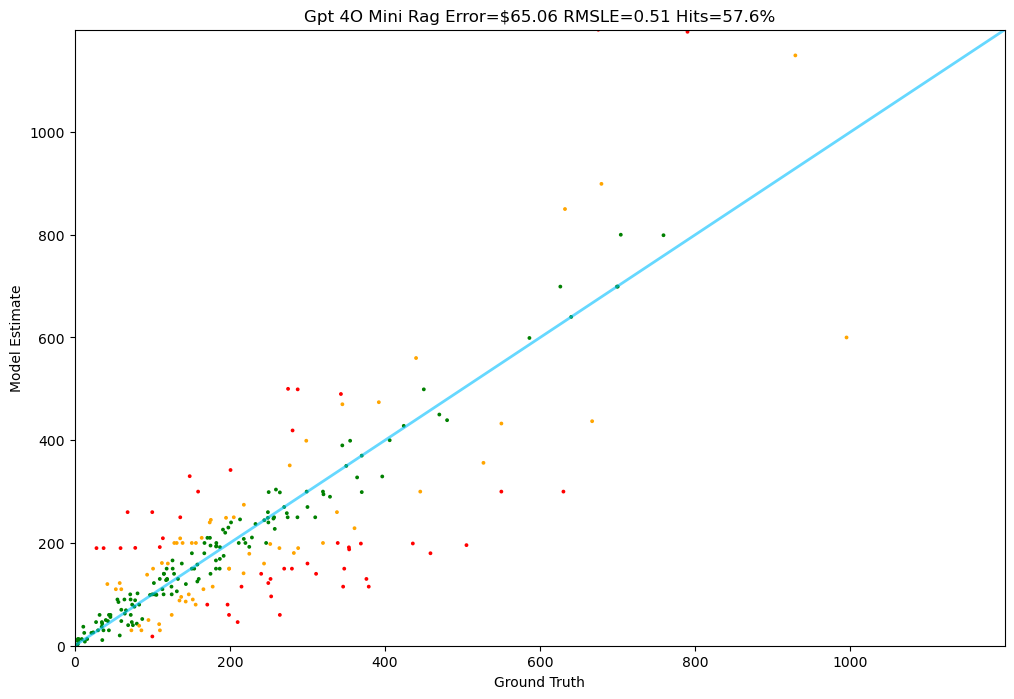

In [24]:
Tester.test(gpt_4o_mini_rag, test)

In [31]:
from agents.frontier_agent import FrontierAgent

In [32]:
agent = FrontierAgent(collection)

In [33]:
agent.price("Quadcast HyperX condenser mic for high quality podcasting")

154.59

In [34]:
from agents.specialist_agent import SpecialistAgent

In [35]:
agent2 = SpecialistAgent()

In [36]:
agent2.price("Quadcast HyperX condenser mic for high quality podcasting")

189.0